In [2]:
"""
Alexandre
2024/10/21
"""

# Trying to simulate some activity in a range of parameters space and trying to decod it with a multinomilae logistic regression

'\nAlexandre\n2024/10/21\n'

# **Encoding and Decoding**

## Initialisation part

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import nest
import os


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug  5 2024 06:09:47

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [4]:
cwd = os.getcwd()
print(cwd)

results_fodler_name = "E_results"
os.makedirs(
    os.path.join(cwd, results_fodler_name),
    exist_ok=True
)

/root/EBRAIN-Fall-School/nest_project_eitn_24/Encoding_Layer_Alexandre


## network generation

In [5]:
# set general parameters
seed = 1
dt = 0.1
num_threads = 8

# initialize nest kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})

# general parameters
gamma = 0.25 # relative number of inhibitory

# encoding layer parameters
nEnc = 500  # number of neurons in the encoding layer
J_bias = 200. # [pA]

# main network parameters
NE = 1000 # number of excitatory neurons (10.000 in [1])
CE = 200 # indegree from excitatory neurons

# synapse parameters
w = 0.1 # excitatory synaptic weight (mV)
g = 5. # relative inhibitory to excitatory synaptic weight
d = 1.5 # synaptic transmission delay (ms)


Oct 24 09:06:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


In [6]:
# create the encoding layer
enc_layer = nest.Create(
    model='iaf_psc_delta', 
    n=nEnc, 
    params={'I_e': J_bias}
)

# record the activity of the encoding layer
enc_spks = nest.Create('spike_recorder')
nest.Connect(enc_layer, enc_spks)

##### MAIN NETWORK #####
# population parameters
NI = int(gamma * NE) # number of inhibitory neurons
CI = int(gamma * CE) # indegree from inhibitory neurons

# neuron paramters
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': 20.,           # spike threshold (mV)
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': 20.,          # membrane time constant (ms)
}

# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create spike detectors
main_spks = nest.Create('spike_recorder')

# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

# spike detector
nest.Connect(neurons_e, main_spks)

# connect the encoding layer to both neuronal population
nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

### generate input

In [7]:
# stimulus parameters
sim_time = 2_000.
frequency = 5e-3
tau = 20
scale = 1.

In [8]:
def gen_stim(
    sim_time=sim_time,
    dt=dt,
    frequency=frequency,
    scale=scale,
    tau=tau
):
    time = np.arange(dt, sim_time, dt)
    pre_sig = (np.sin(2 * np.pi * time * frequency) + 1) / 2 * scale

    noise = np.zeros_like(time)
    for t in range(len(noise)-1):
        n = np.random.randn() * 2
        noise[t+1] = (1-dt/tau)*noise[t]+ (dt*n/tau)

    sig = pre_sig + noise

    return time, sig, pre_sig

### connection between input and encoding layer

In [9]:
frequency_1 = 0.005
frequency_2 = 0.01
scale = 1
tau_1 = 20
tau_2 = 5

In [21]:
time, sig_1, pre_sig_1 = gen_stim(
    sim_time=sim_time, dt=dt,
    frequency=frequency_1, scale=scale,
    tau=tau_1
)

time, sig_2, pre_sig_2 = gen_stim(
    sim_time=sim_time, dt=dt,
    frequency=frequency_2, scale=scale,
    tau=tau_2
)

sig = sig_1 * sig_2

print(sig.shape)

(19999,)


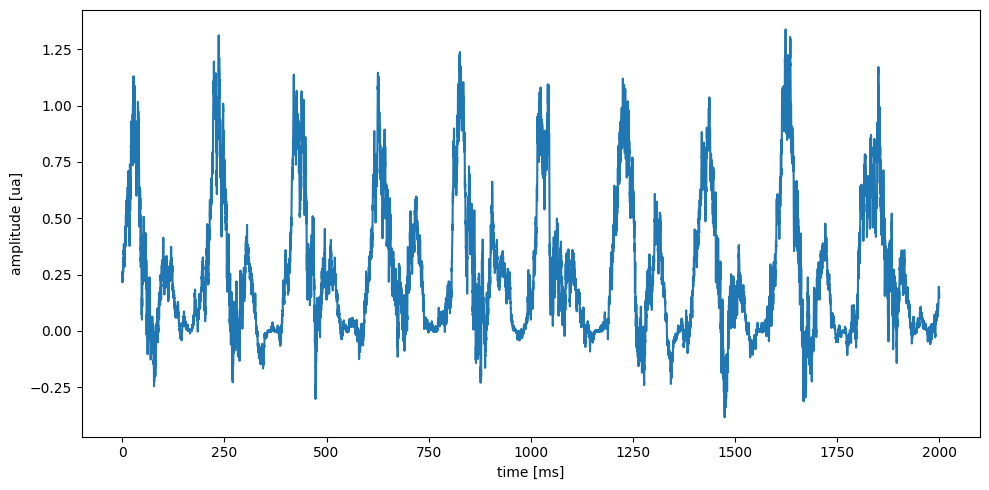

In [12]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,5)
)

ax.plot(
    time,
    sig
)

ax.set_xlabel("time [ms]")
ax.set_ylabel("amplitude [ua]")

plt.tight_layout()
plt.show()

In [13]:
# encoding layer 1 reparametrisation
tuning = 250. * np.random.randn(nEnc) + 1000. # 
thresholds = 5 * np.random.randn(nEnc) - 50. # generate some heterogeneity on the population
thresholds = np.maximum(thresholds, -65.) # 
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc))) # randomized initiate point of each neuron

In [14]:
step_generator = nest.Create(
    model='step_current_generator', 
    n=nEnc
)

amplitudes = np.zeros((nEnc, len(sig)))

for n in range(nEnc): # for each neuron in the encoding layer
    
    # transform the input as function of the tuning of each neuron
    amplitudes[n, :] = sig * tuning[n]
    
    # change parameters of each neuron in the input layer
    enc_layer[n].set(
        {
            'V_m': Vm0[n], # set the membrane potential initialisation
            'V_th': thresholds[n] # set the excitation threshold
        }
    )

    # change caracteristics of the input generator
    step_generator[n].set(
        {
            'amplitude_times': time, # set the time
            'amplitude_values': amplitudes[n] # set the amplitude
        }
    )

    # connect the input generator to the encoding layer neuron one-by-one
    nest.Connect(
        step_generator[n],
        enc_layer[n]
    )

### run the simulation

In [15]:
# run the simulation
nest.Simulate(sim_time)


Oct 24 09:06:33 NodeManager::prepare_nodes [Info]: 
    Preparing 5766 nodes for simulation.

Oct 24 09:06:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5766
    Simulation time (ms): 2000
    Number of OpenMP threads: 8
    Number of MPI processes: 1

Oct 24 09:06:35 SimulationManager::run [Info]: 
    Simulation finished.


### extract results

In [16]:
# extract the simulation results
from utils.extractors import filter_spikes_parallel

filter_tau = 20. # [ms]

In [17]:
enc_activity = enc_spks.events
enc_states = filter_spikes_parallel(
    enc_activity['times'], enc_activity['senders'], # use the timing and the origin of each spike of the encoding layer
    nEnc, # total number of neuron in the encoding layer
    t_start=dt, t_stop=sim_time, dt=dt, # begin, end and time-step of the simulation
    tau=filter_tau, 
    n_processes=num_threads
)


main_activity = main_spks.events
main_states = filter_spikes_parallel(
    main_activity['times'], main_activity['senders'], 
    NE, 
    t_start=dt, t_stop=sim_time, dt=dt, 
    tau=filter_tau, 
    n_processes=num_threads
)

Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:27<00:00, 35.83it/s]


### decoding

In [18]:
from sklearn.linear_model import LinearRegression

In [19]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(
        n_jobs=-1, 
        fit_intercept=False
    ).fit(x.T, z)
    
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

In [20]:
enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig)
main_estimate, main_capacity, main_error = compute_capacity(main_states, sig)

print(f"Encoding Layer 1: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")

Encoding Layer 1: 
	- Capacity=0.830370035452295, MSE=0.01570574511616551
Main Circuit: 
	- Capacity=0.6188070104601973, MSE=0.046196433312223256


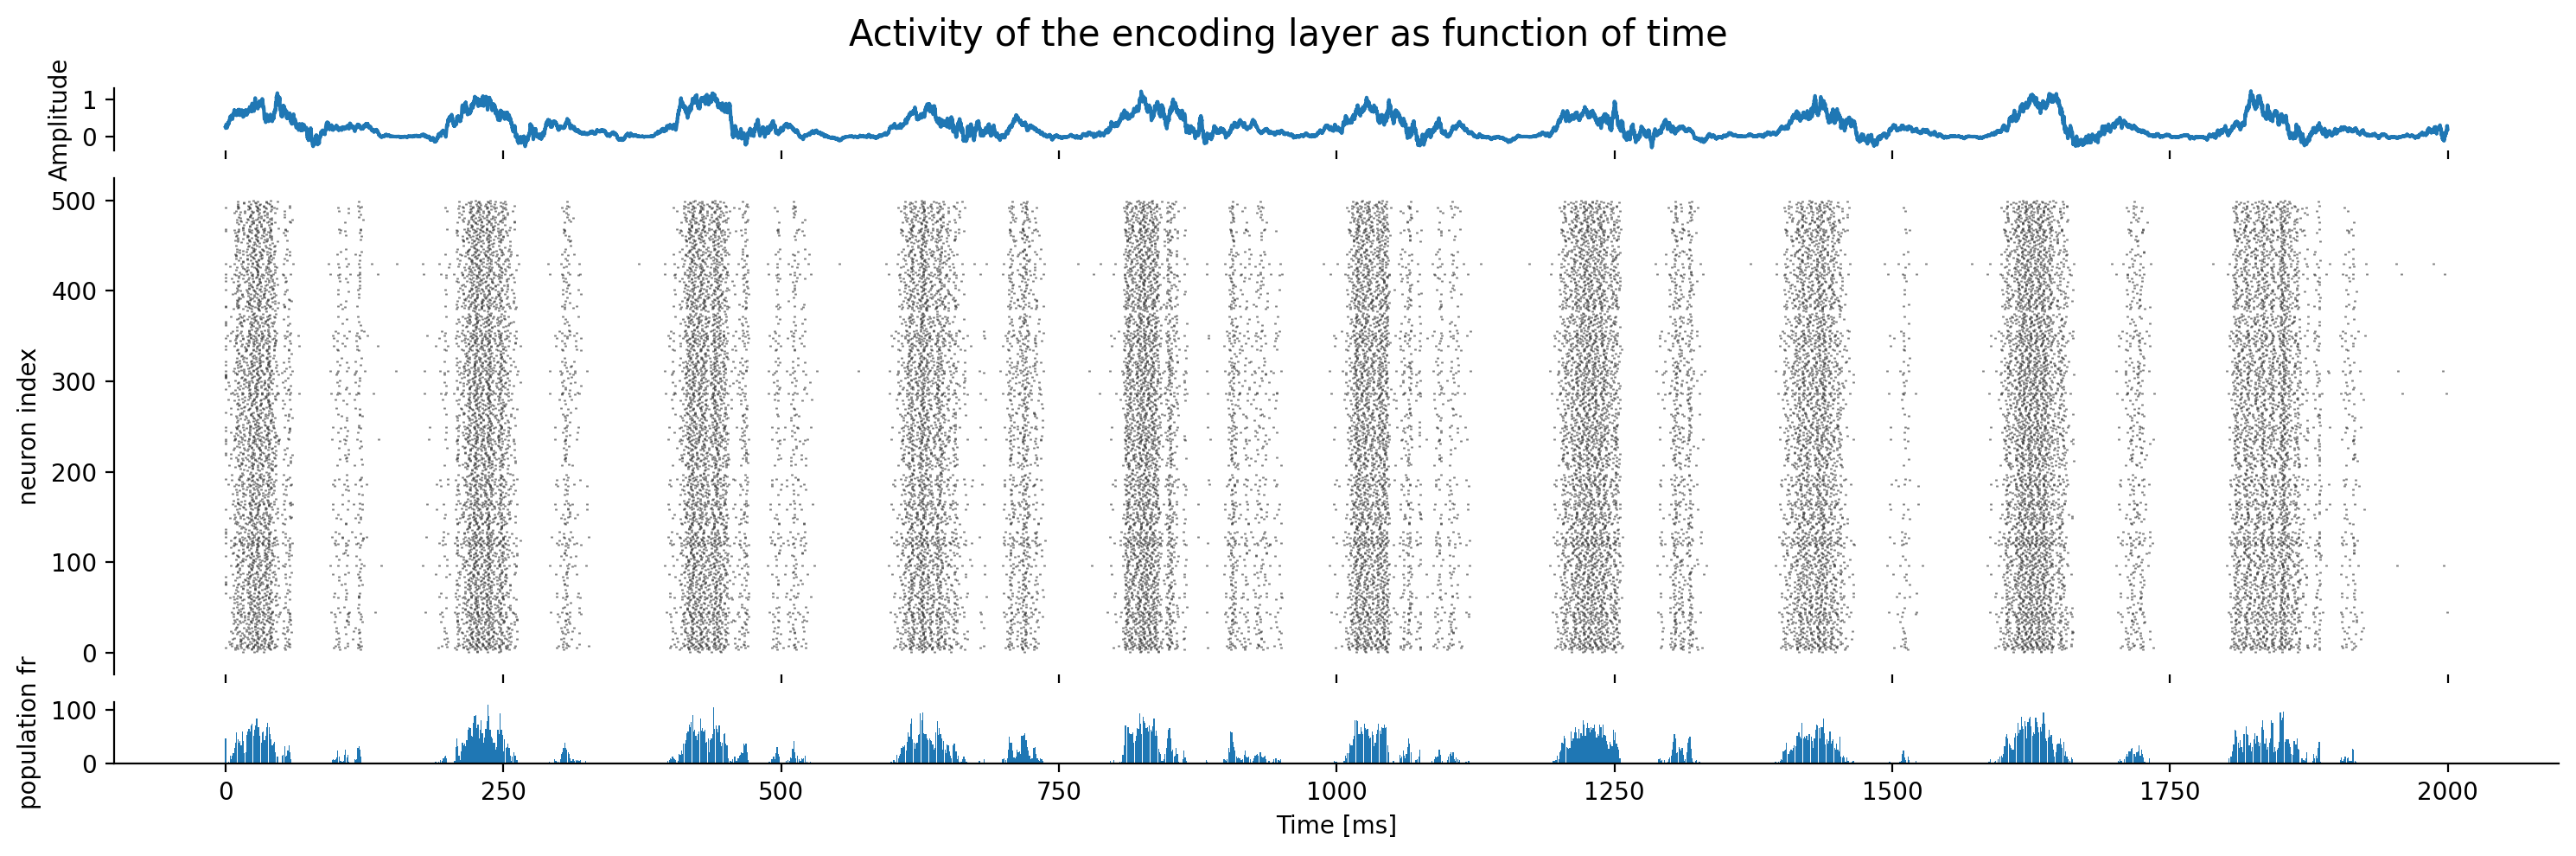

In [22]:
# graphical representation of the encoding layer spiking activity
fig,ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.1,0.8,0.1]},
    sharex=True
)

ax[0].plot(
    time,
    sig
)

ax[1].plot(
    enc_spks.events["times"],
    enc_spks.events["senders"],
    "|", color="black",
    markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    enc_spks.events["times"],
    bins=np.linspace(
        enc_spks.events["times"].min(), 
        enc_spks.events["times"].max(), 
        int(enc_spks.events["times"].max())
    )
)

ax[2].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_ylabel(r'Amplitude')
ax[0].spines[["top","right","bottom"]].set_visible(False)

ax[1].set_ylabel(r"neuron index")
ax[1].spines[["top","bottom","right"]].set_visible(False)

ax[2].set_ylabel(r"population fr")
ax[2].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the encoding layer as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_encoding_layer.pdf"), dpi=200)
plt.show()

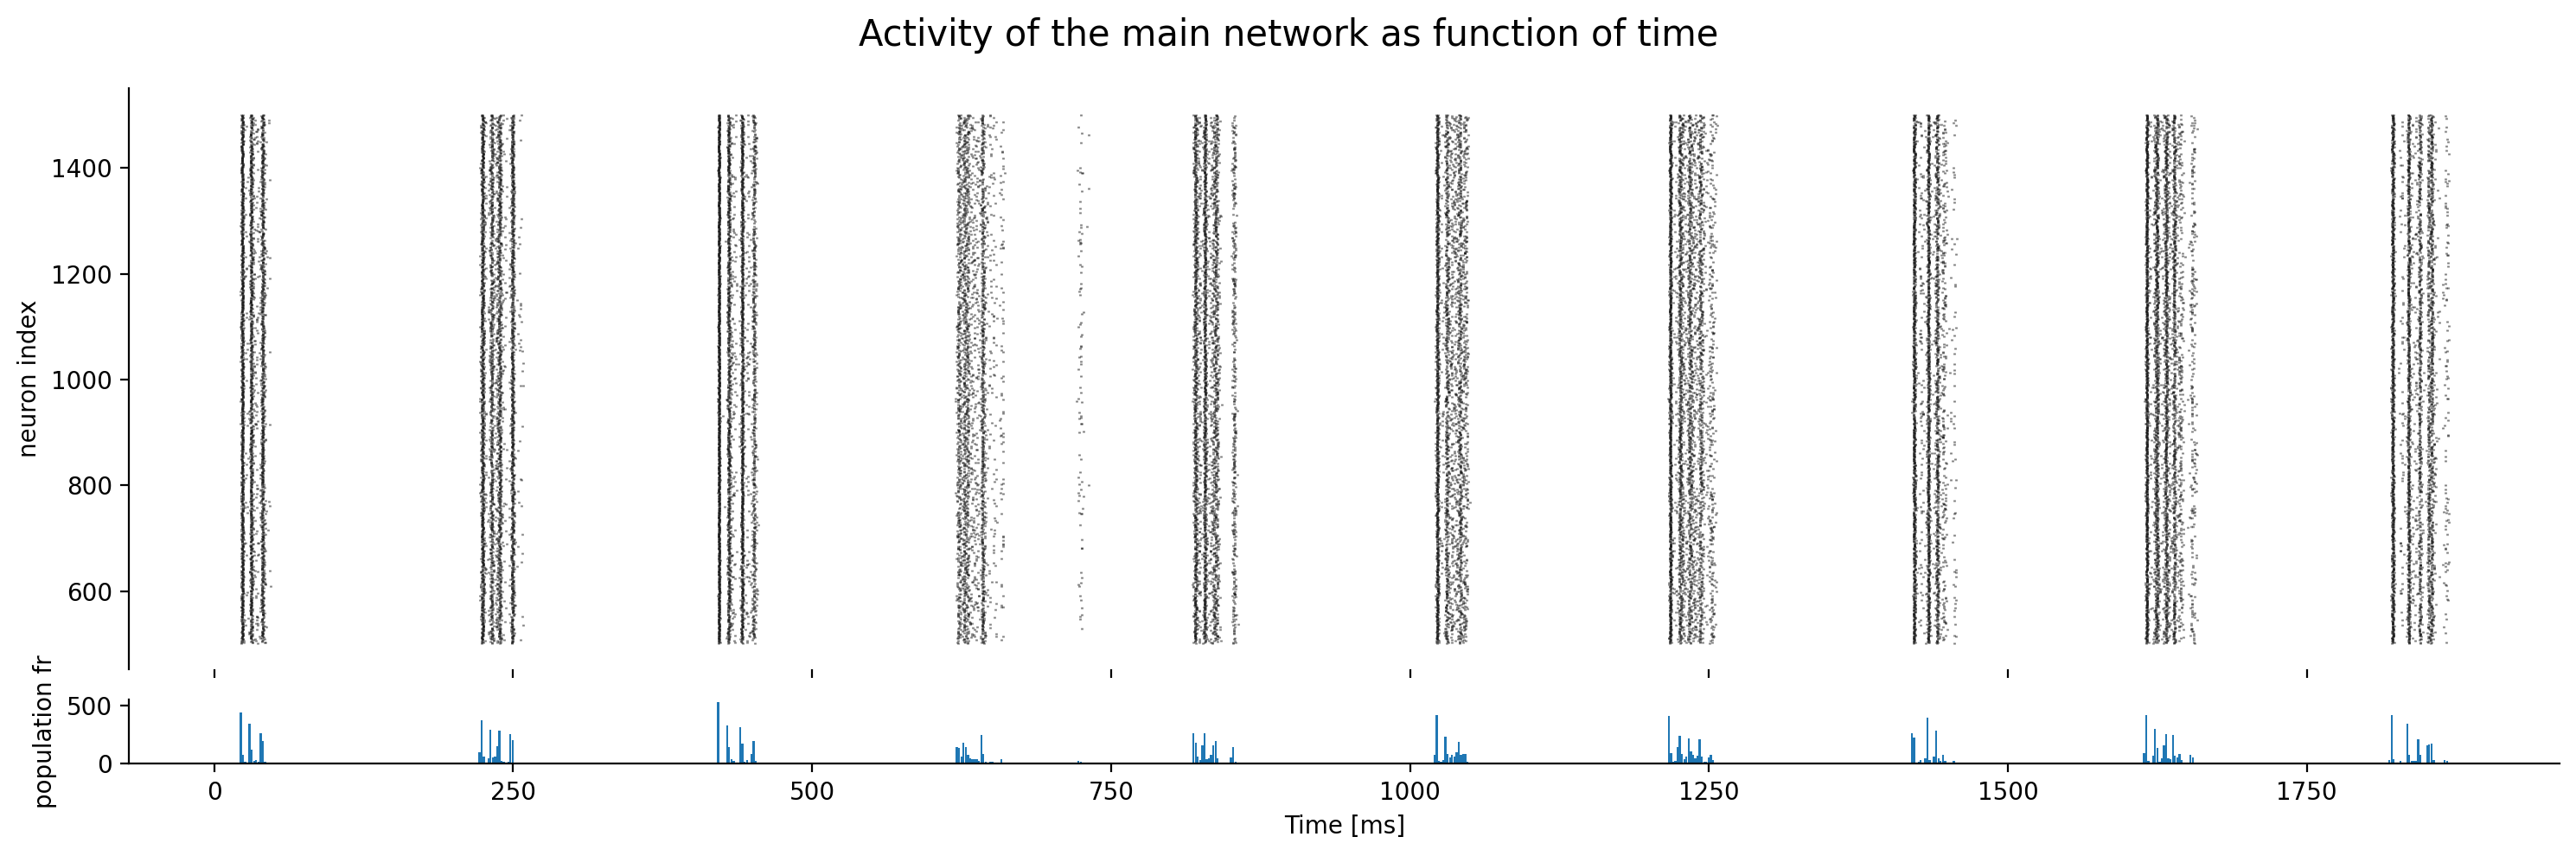

In [23]:
# graphical representation of the main network
fig,ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.9,0.1]},
    sharex=True
)

ax[0].plot(
    main_spks.events["times"],
    main_spks.events["senders"],
    "|", color="black",
    markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    main_spks.events["times"],
    bins=np.linspace(main_spks.events["times"].min(), main_spks.events["times"].max(), 1_000)
)

ax[1].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_ylabel(r"neuron index")
ax[0].spines[["top","bottom","right"]].set_visible(False)

ax[1].set_ylabel(r"population fr")
ax[1].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the main network as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_main_network.pdf"), dpi=200)
plt.show()

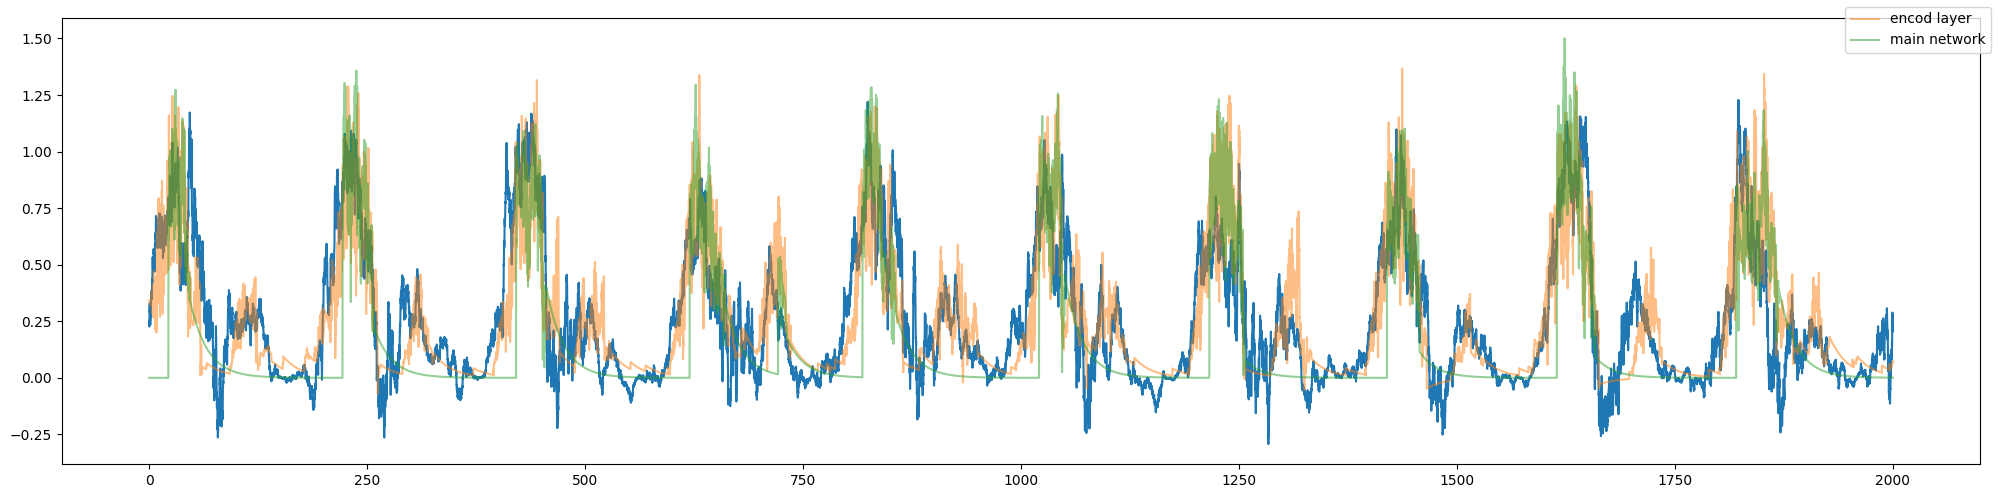

In [24]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(20,5)
)

ax.plot(
    time,
    sig
)

ax.plot(
    time,
    enc_estimate,
    alpha=0.5,
    label="encod layer"
)

ax.plot(
    time,
    main_estimate,
    alpha=0.5,
    label="main network"
)

# ax.set_xlim(0,1_000)
fig.legend()

plt.tight_layout()
plt.show()

In [25]:
from sklearn.decomposition import PCA

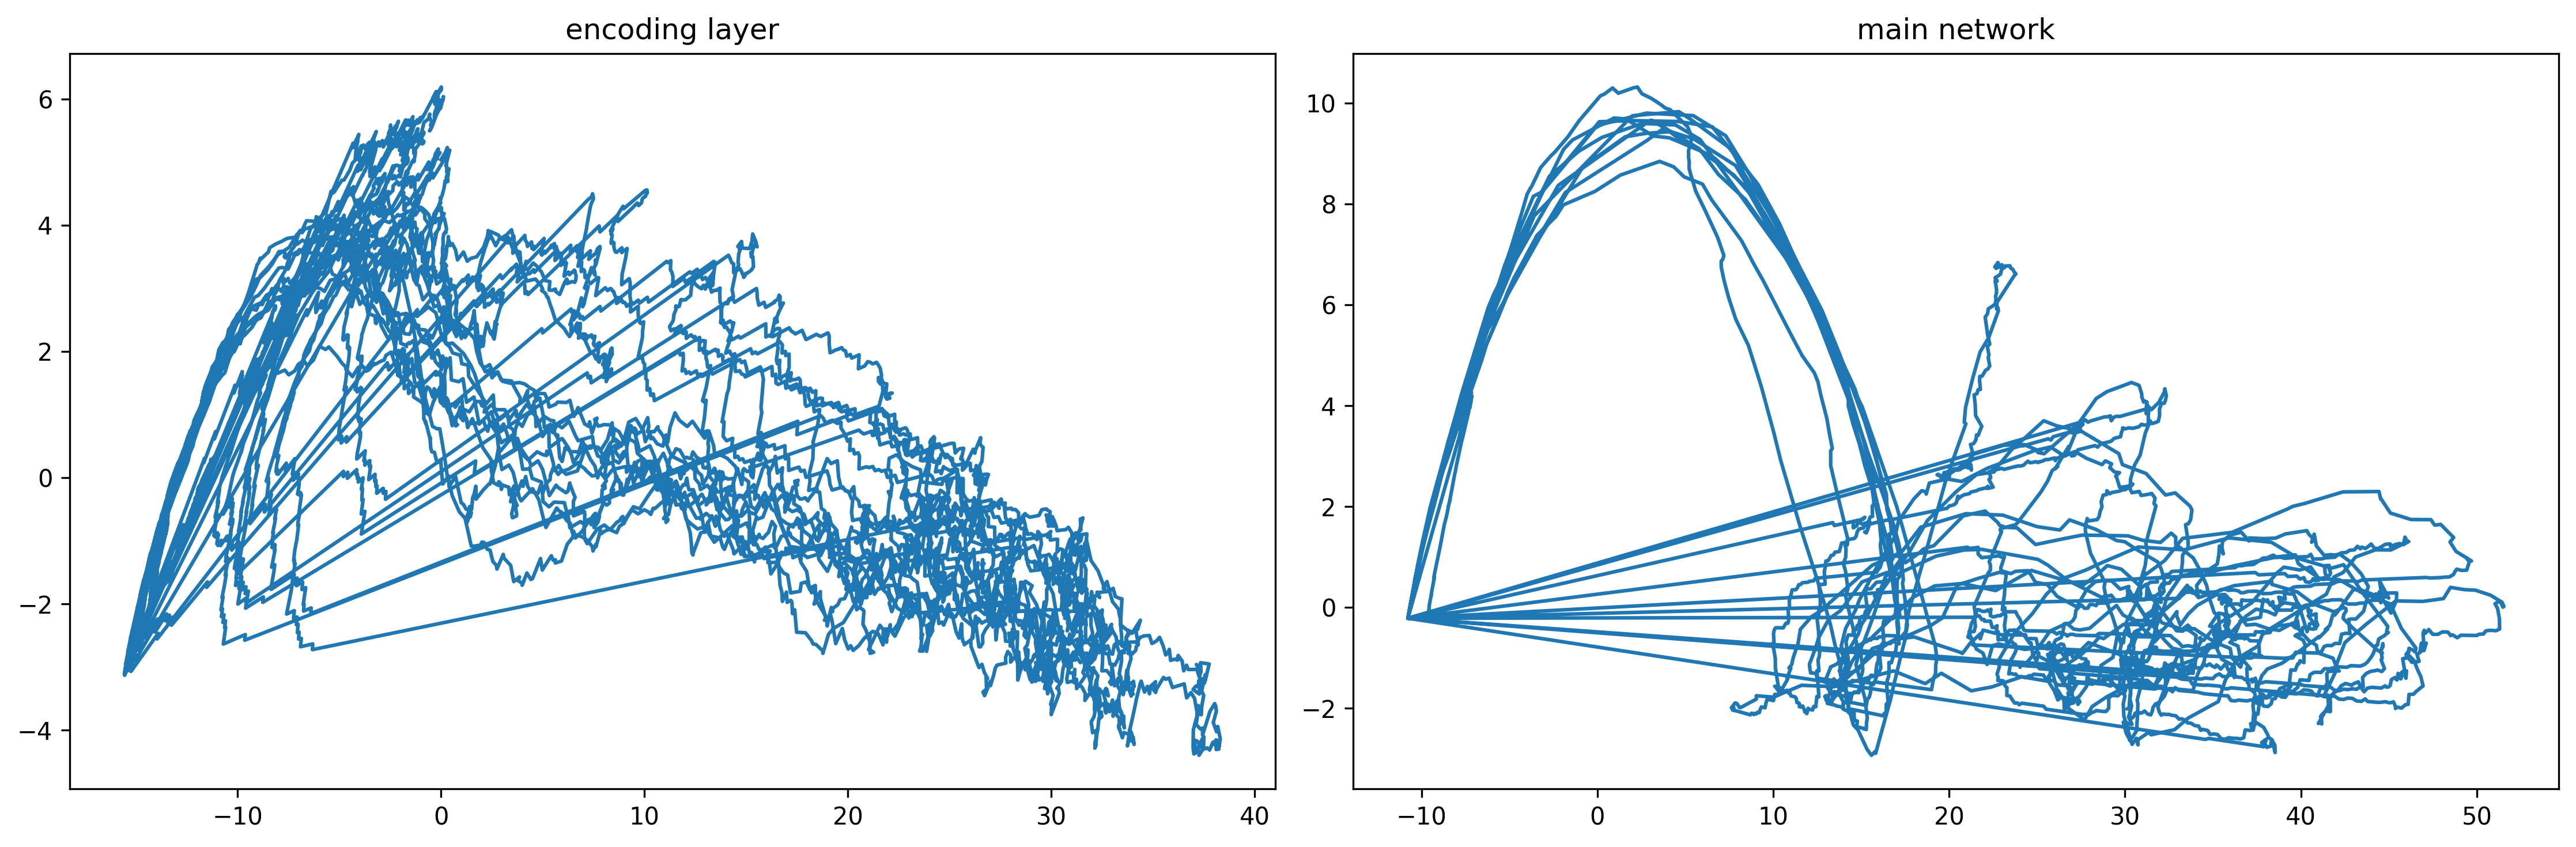

In [26]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5),
    dpi=300
)

for iX,X in enumerate([enc_states, main_states]):

    components = PCA(n_components=10).fit_transform(X.T)
    
    ax[iX].plot(
        components[:,0],
        components[:,1]
    )

ax[0].set_title("encoding layer")
ax[1].set_title("main network")

plt.tight_layout()
plt.show()

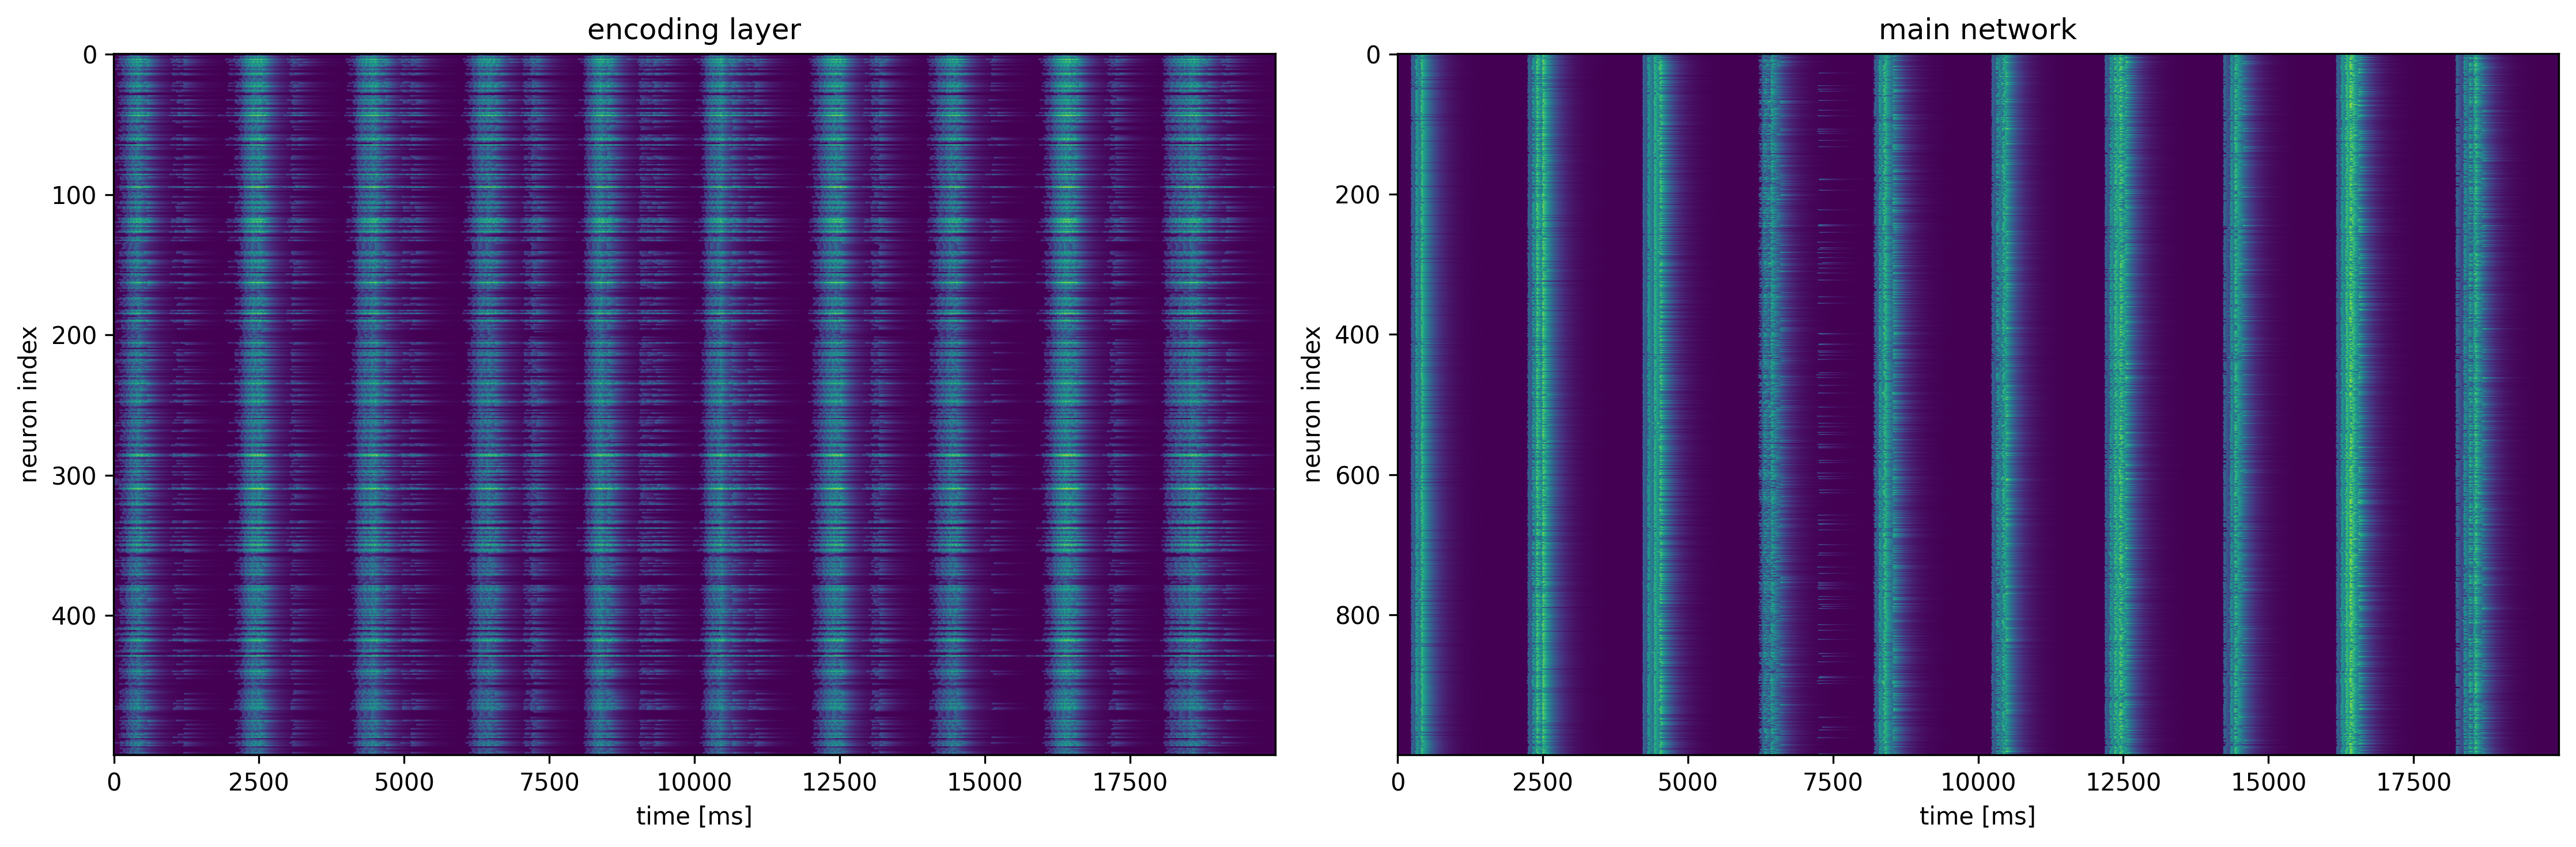

In [27]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5),
    dpi=300
)

for iX,X in enumerate([enc_states, main_states]):
    
    ax[iX].imshow(
        X,
        aspect="auto",
    )

ax[0].set_title("encoding layer")
ax[1].set_title("main network")

ax[0].set_xlabel("time [ms]")
ax[1].set_xlabel("time [ms]")

ax[0].set_ylabel("neuron index")
ax[1].set_ylabel("neuron index")

plt.tight_layout()
plt.show()

In [77]:
subsampling_factor = 1 # ms
max_lag = 100 # ms
step_lag = 5.0 / subsampling_factor

def compute_capacity_sequential(
    time_vector,
    signal,
    enc_states,
    ex_states,
    subsampling_factor,
    max_lag=100.0,
    step_lag=10,
    dt=0.1,
    verbose=False
):
    """

    Parameters
    ----------
    time_vector
    signal
    enc_states
    ex_states
    subsampling_factor
    max_lag : float
        Maximum lag / delay for which to evaluate memory capacity
    dt

    Returns
    -------

    """
    # Adjust the maximum lag and step lag based on the subsampling factor
    max_lag_subsampled = max_lag / subsampling_factor  # in milliseconds
    step_lag_subsampled = step_lag / subsampling_factor  # default step is 10 ms, scaled by subsampling factor

    # Create the array of time lags (subsampled) based on max_lag and step_lag
    time_lags = np.arange(dt, max_lag_subsampled, step_lag_subsampled)

    # Find indices in the time vector corresponding to these time lags
    indices = [np.where(time_vector == lag)[0][0] for lag in time_lags]

    # Compute the initial index for subsampling based on subsampling factor and dt
    initial_index = max(0, int(subsampling_factor * dt))

    # Generate the indices for subsampling the signal
    subsampling_indices = np.arange(initial_index, len(signal) + initial_index, subsampling_factor, dtype=int)

    # Subsample the signal using the generated indices
    subsampled_signal = signal[subsampling_indices]

    # Initialize lists to store capacities
    encoder_capacity = []
    circuit_capacity = []

    for shift, lag in zip(indices, time_lags):
        # shift the target signal
        if shift > 0:
            shifted_signal = subsampled_signal[:-shift]
        else:
            shifted_signal = subsampled_signal

        # shift the population states
        enc_st = enc_states[:, shift:]
        circ_st = ex_states[:, shift:]

        # compute capacity
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)
        circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)

        if verbose:
            print(f"Lag = {lag * subsampling_factor} ms")
            print(f"Encoding Layer: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
            print(f"Main Circuit: \n\t- Capacity={circ_capacity}, MSE={circ_error}")

        encoder_capacity.append(enc_capacity)
        circuit_capacity.append(circ_capacity)

    return time_lags * subsampling_factor, encoder_capacity, circuit_capacity

In [78]:
time_capacity, encoder_capacity, main_capacity = compute_capacity_sequential(
    time_vector=time,
    signal=sig, 
    enc_states=enc_states,
    ex_states=main_states,
    subsampling_factor=subsampling_factor,
    max_lag=max_lag,
    step_lag=step_lag,
    dt=dt,
    verbose=True
)

Lag = 0.1 ms
Encoding Layer: 
	- Capacity=0.9253785592845879, MSE=0.010628037339418502
Main Circuit: 
	- Capacity=0.8383052653720661, MSE=0.03337309317564413
Lag = 5.1 ms
Encoding Layer: 
	- Capacity=0.9591959703180645, MSE=0.005898621179288205
Main Circuit: 
	- Capacity=0.8836376213869579, MSE=0.022638441969237325
Lag = 10.1 ms
Encoding Layer: 
	- Capacity=0.9795896774922908, MSE=0.0030123448847979625
Main Circuit: 
	- Capacity=0.9228992459326895, MSE=0.01411657431302498
Lag = 15.1 ms
Encoding Layer: 
	- Capacity=0.9870938555136249, MSE=0.0019509694616326341
Main Circuit: 
	- Capacity=0.9616452583450755, MSE=0.006752871473113042
Lag = 20.1 ms
Encoding Layer: 
	- Capacity=0.9817767930842314, MSE=0.002735770869090699
Main Circuit: 
	- Capacity=0.9733052731915938, MSE=0.004644372185063639
Lag = 25.1 ms
Encoding Layer: 
	- Capacity=0.9668570954966682, MSE=0.004931781022824751
Main Circuit: 
	- Capacity=0.9749053014749699, MSE=0.004345223682837789
Lag = 30.1 ms
Encoding Layer: 
	- Capacity

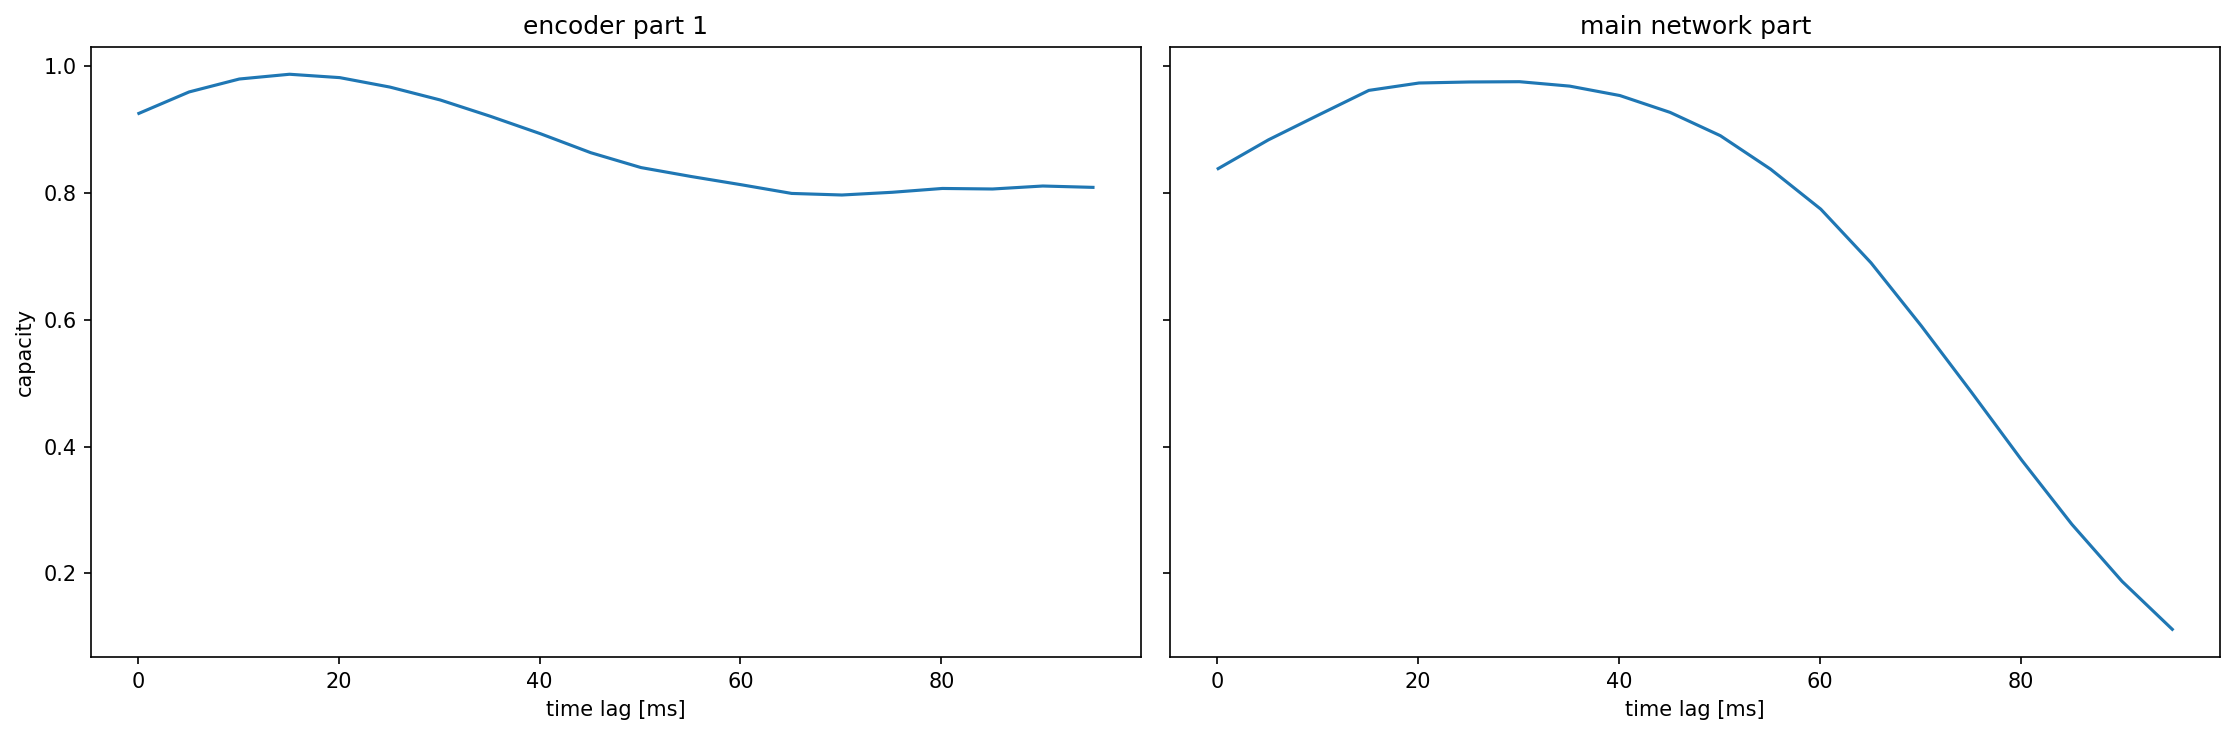

Total capacity (encoder): 87.66092359934233 ms
Total capacity (processor): 73.01363029353432 ms


In [79]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15,5),
    dpi=150,
    sharey=True
)

ax[0].plot(
    time_capacity,
    encoder_capacity
)
ax[0].set_title("encoder part 1")
ax[0].set_ylabel("capacity")
ax[0].set_xlabel("time lag [ms]")

ax[1].plot(
    time_capacity,
    main_capacity
)
ax[1].set_title("main network part")
ax[1].set_xlabel("time lag [ms]")

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "memory_capacity.pdf"))
plt.show()

print(f"Total capacity (encoder): {np.sum(encoder_capacity)*step_lag} ms")
print(f"Total capacity (processor): {np.sum(main_capacity)*step_lag} ms")

## Data generation

In [80]:
frequency_range = np.linspace(1e-4, 1e-2, 3)
scale_range = np.linspace(0.5, 5, 3)
repet = 5

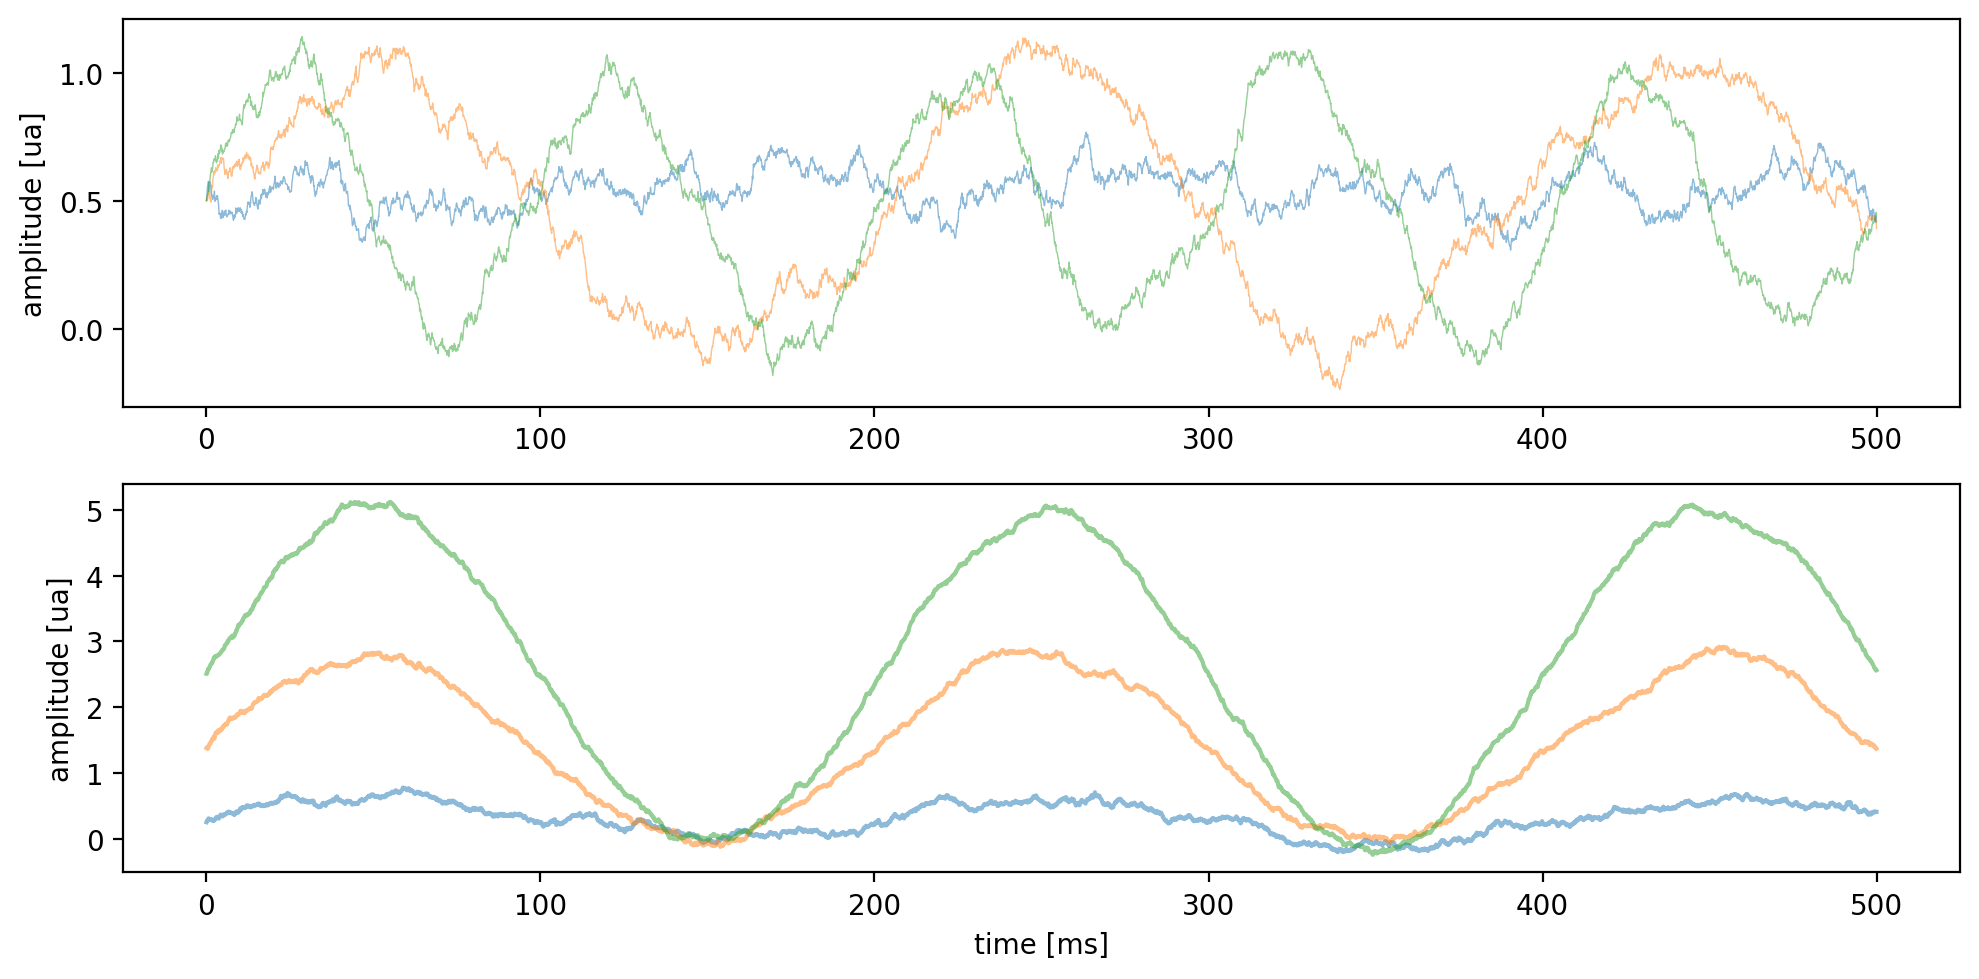

In [81]:
fig,ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10,5),
    dpi=200
)

for f in frequency_range:
    
    time, sig, pre_sig = gen_stim(
        sim_time=sim_time, dt=dt,
        frequency=f
    )

    ax[0].plot(
        time,
        sig,
        linewidth=0.5,
        alpha=0.5
    )

for s in scale_range:

    time, sig, pre_sig = gen_stim(
        sim_time=sim_time, dt=dt,
        scale=s
    )

    ax[1].plot(
        time,
        sig,
        alpha=0.5
    )

ax[0].set_ylabel("amplitude [ua]")
ax[1].set_ylabel("amplitude [ua]")
ax[1].set_xlabel("time [ms]")

plt.tight_layout()
plt.show()

In [82]:
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [83]:
stim = []
label = []

for n in range(repet):

    for f in frequency_range:
        
        for s in scale_range:

            time, sig, pre_sig = gen_stim(
                sim_time=sim_time, dt=dt,
                scale=s, frequency=f
            )

            stim.append(sig)
            label.append(f"freq{f:.3f}_scl{s}")
            
model = LabelEncoder().fit(label)
label = model.transform(label)
stim = np.array(stim)

np.save(os.path.join(results_fodler_name, "stimuli", "stim"), stim)
np.save(os.path.join(results_fodler_name, "stimuli", "label"), label)
np.save(os.path.join(results_fodler_name, "stimuli", "time"), time)

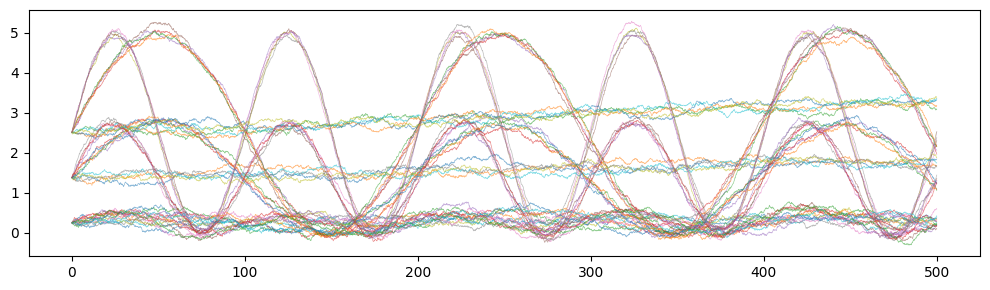

In [84]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,3)
)

ax.plot(
    time,
    stim.T,
    alpha=0.5,
    linewidth=0.5
)

plt.tight_layout()
plt.show()

## Record the network activity

In [85]:
pplt = False

In [86]:
stim.shape, label.shape, time.shape

((45, 4999), (45,), (4999,))

In [ ]:
activity = []

for i_stim in range(stim.shape[0]):

    print(f"########## {model.inverse_transform(label)[i_stim]}")

    # set general parameters
    seed = 1
    dt = 0.1
    num_threads = 16

    ####################################
    ###### initialize nest kernel ######
    ####################################

    nest.ResetKernel()
    nest.SetKernelStatus({
        'rng_seed': seed,
        'resolution': dt,
        'local_num_threads': num_threads
    })

    ####################################
    #### create the encoding layer #####
    ####################################

    enc_layer = nest.Create(
        model='iaf_psc_delta', 
        n=nEnc, 
        params={'I_e': J_bias}
    )

    # record the activity of the encoding layer 1
    enc_spks = nest.Create('spike_recorder')
    nest.Connect(enc_layer, enc_spks)

    ####################################
    ##### create the main network ######
    ####################################

    # population parameters
    NI = int(gamma * NE) # number of inhibitory neurons
    CI = int(gamma * CE) # indegree from inhibitory neurons

    # neuron paramters
    neuron_params = {
        'C_m': 1.0,            # membrane capacity (pF)
        'E_L': 0.,             # resting membrane potential (mV)
        'I_e': 0.,             # external input current (pA)
        'V_m': 0.,             # membrane potential (mV)
        'V_reset': 10.,        # reset membrane potential after a spike (mV)
        'V_th': 20.,           # spike threshold (mV)
        't_ref': 2.0,          # refractory period (ms)
        'tau_m': 20.,          # membrane time constant (ms)
    }

    # set default parameters for neurons and create neurons
    nest.SetDefaults('iaf_psc_delta', neuron_params)
    neurons_e = nest.Create('iaf_psc_delta', NE)
    neurons_i = nest.Create('iaf_psc_delta', NI)

    # create spike detectors
    main_spks = nest.Create('spike_recorder')

    # E synapses
    syn_exc = {'delay': d, 'weight': w}
    conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
    nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
    nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

    # I synapses
    syn_inh = {'delay': d, 'weight': - g * w}
    conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
    nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
    nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

    # spike detector
    nest.Connect(neurons_e, main_spks)

    # connect the encoding layer to both neuronal population
    nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
    nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)
    
    ###################################
    # connect input to encoding layer #
    ###################################

    sig = stim[i_stim,:]
    
    # encoding layer 1 reparametrisation
    tuning = 250. * np.random.randn(nEnc) + 1000. # 
    thresholds = 5 * np.random.randn(nEnc) - 50. # generate some heterogeneity on the population
    thresholds = np.maximum(thresholds, -65.) # 
    Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc))) # randomized initiate point of each neuron

    step_generator = nest.Create(
        model='step_current_generator', 
        n=nEnc
    )

    amplitudes = np.zeros((nEnc, len(sig)))

    for n in range(nEnc): # for each neuron in the encoding layer
        
        # transform the input as function of the tuning of each neuron
        amplitudes[n, :] = sig * tuning[n]
        
        # change parameters of each neuron in the input layer
        enc_layer[n].set(
            {
                'V_m': Vm0[n], # set the membrane potential initialisation
                'V_th': thresholds[n] # set the excitation threshold
            }
        )

        # change caracteristics of the input generator
        step_generator[n].set(
            {
                'amplitude_times': time, # set the time
                'amplitude_values': amplitudes[n] # set the amplitude
            }
        )

        # connect the input generator to the encoding layer neuron one-by-one
        nest.Connect(
            step_generator[n],
            enc_layer[n]
        )

    ###########################################
    # run the simulation and extract activity #
    ###########################################

    nest.Simulate(sim_time)

    enc_activity = enc_spks.events
    enc_states = filter_spikes_parallel(
        enc_activity['times'], enc_activity['senders'], # use the timing and the origin of each spike of the encoding layer
        nEnc, # total number of neuron in the encoding layer
        t_start=dt, t_stop=sim_time, dt=dt, # begin, end and time-step of the simulation
        tau=filter_tau, 
        n_processes=num_threads
    )
    
    main_activity = main_spks.events
    main_states = filter_spikes_parallel(
        main_activity['times'], main_activity['senders'], 
        NE, 
        t_start=dt, t_stop=sim_time, dt=dt, 
        tau=filter_tau, 
        n_processes=num_threads
    )

    # save the activity of the main network
    activity.append(main_states)

    ###########################################
    #### decod the input from the activity ####
    ###########################################
    enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig)
    main_estimate, main_capacity, main_error = compute_capacity(main_states, sig)

    print(f"Encoding Layer 1: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
    print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")

    if pplt:
        
        fig,ax = plt.subplots(
            nrows=3,
            ncols=1,
            figsize=(15,5),
            dpi=200,
            gridspec_kw={"height_ratios":[0.1,0.8,0.1]},
            sharex=True
        )
        ax[0].plot(
            time,
            sig
        )
        ax[1].plot(
            enc_spks.events["times"],
            enc_spks.events["senders"],
            "|", color="black",
            markersize=1,
            alpha=0.5
        )
        values, bins = np.histogram(
            enc_spks.events["times"],
            bins=np.linspace(
                enc_spks.events["times"].min(), 
                enc_spks.events["times"].max(), 
                int(enc_spks.events["times"].max())
            )
        )
        ax[2].bar(
            x=bins[:-1],
            height=values/(bins[1]-bins[0]),
            width=(bins[1]-bins[0])/1.1
        )
        ax[0].set_ylabel(r'Amplitude')
        ax[0].spines[["top","right","bottom"]].set_visible(False)
        ax[1].set_ylabel(r"neuron index")
        ax[1].spines[["top","bottom","right"]].set_visible(False)
        ax[2].set_ylabel(r"population fr")
        ax[2].spines[["top","right"]].set_visible(False)
        ax[-1].set_xlabel(r'Time [ms]')
        fig.suptitle("Activity of the encoding layer as function of time", size=15)
        plt.tight_layout()
        plt.show()

        fig,ax = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(15,5),
            dpi=200,
            gridspec_kw={"height_ratios":[0.9,0.1]},
            sharex=True
        )
        ax[0].plot(
            main_spks.events["times"],
            main_spks.events["senders"],
            "|", color="black",
            markersize=1,
            alpha=0.5
        )
        values, bins = np.histogram(
            main_spks.events["times"],
            bins=np.linspace(main_spks.events["times"].min(), main_spks.events["times"].max(), 1_000)
        )
        ax[1].bar(
            x=bins[:-1],
            height=values/(bins[1]-bins[0]),
            width=(bins[1]-bins[0])/1.1
        )
        ax[0].set_ylabel(r"neuron index")
        ax[0].spines[["top","bottom","right"]].set_visible(False)
        ax[1].set_ylabel(r"population fr")
        ax[1].spines[["top","right"]].set_visible(False)
        ax[-1].set_xlabel(r'Time [ms]')
        fig.suptitle("Activity of the main network as function of time", size=15)
        plt.tight_layout()
        plt.show()

        fig, ax = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(20,5)
        )
        ax.plot(
            time,
            sig
        )
        ax.plot(
            time,
            enc_estimate,
            alpha=0.5,
            label="encod layer"
        )
        ax.plot(
            time,
            main_estimate,
            alpha=0.5,
            label="main network"
        )
        fig.legend()
        plt.tight_layout()
        plt.show()

activity = np.array(activity)
np.save(os.path.join(results_fodler_name, ))

########## freq0.000_scl0.5

Oct 22 17:21:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:21:57 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:21:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:21:58 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 181.61it/s]


Encoding Layer 1: 
	- Capacity=0.8898064279019295, MSE=0.001297630705197301
Main Circuit: 
	- Capacity=0.39619639531632006, MSE=0.03757996013443163
########## freq0.000_scl2.75

Oct 22 17:22:12 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:22:13 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:22:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:22:14 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 158.46it/s]


Encoding Layer 1: 
	- Capacity=0.7448638811169679, MSE=0.007231656437274413
Main Circuit: 
	- Capacity=0.578738051950058, MSE=0.032197943407765266
########## freq0.000_scl5.0

Oct 22 17:22:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:22:26 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:22:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:22:28 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 180.74it/s]


Encoding Layer 1: 
	- Capacity=0.6728176790328795, MSE=0.02292972957285809
Main Circuit: 
	- Capacity=0.454529480821734, MSE=0.12429342217336549
########## freq0.005_scl0.5

Oct 22 17:22:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:22:41 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:22:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:22:42 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 167.00it/s]


Encoding Layer 1: 
	- Capacity=0.93760351167152, MSE=0.002677381785362313
Main Circuit: 
	- Capacity=0.490310649459923, MSE=0.03227515559925778
########## freq0.005_scl2.75

Oct 22 17:22:53 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:22:55 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:22:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:22:56 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 180.07it/s]


Encoding Layer 1: 
	- Capacity=0.8426009837190412, MSE=0.14910374585060482
Main Circuit: 
	- Capacity=0.9307746850301482, MSE=0.07877688697695785
########## freq0.005_scl5.0

Oct 22 17:23:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:23:07 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:23:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:23:08 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 187.61it/s]


Encoding Layer 1: 
	- Capacity=0.8250142403350268, MSE=0.5452340213220023
Main Circuit: 
	- Capacity=0.9400192473027009, MSE=0.20699801564854667
########## freq0.010_scl0.5

Oct 22 17:23:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:23:19 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:23:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:23:20 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 197.60it/s]


Encoding Layer 1: 
	- Capacity=0.8826320262667924, MSE=0.0052998498447564615
Main Circuit: 
	- Capacity=0.14429546176114877, MSE=0.05526573351682999
########## freq0.010_scl2.75

Oct 22 17:23:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:23:31 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:23:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:23:33 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 172.67it/s]


Encoding Layer 1: 
	- Capacity=0.7458319068976494, MSE=0.2533982145867767
Main Circuit: 
	- Capacity=0.8785526940748474, MSE=0.13718254442946004
########## freq0.010_scl5.0

Oct 22 17:23:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:23:45 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:23:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:23:47 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 181.90it/s]


Encoding Layer 1: 
	- Capacity=0.691484006997494, MSE=0.9646882748390787
Main Circuit: 
	- Capacity=0.8863703748514687, MSE=0.38361520845869695
########## freq0.000_scl0.5

Oct 22 17:23:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:23:58 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:23:58 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:23:59 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 190.83it/s]


Encoding Layer 1: 
	- Capacity=0.8313946482620177, MSE=0.0012902117268433697
Main Circuit: 
	- Capacity=0.21430215083318474, MSE=0.05939621612827476
########## freq0.000_scl2.75

Oct 22 17:24:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:24:09 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:24:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:24:10 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 178.24it/s]


Encoding Layer 1: 
	- Capacity=0.7474882529927395, MSE=0.008286921791434657
Main Circuit: 
	- Capacity=0.5289873519460939, MSE=0.04032681127290391
########## freq0.000_scl5.0

Oct 22 17:24:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:24:22 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:24:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:24:24 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 174.39it/s]


Encoding Layer 1: 
	- Capacity=0.7375916094287281, MSE=0.021949987432900588
Main Circuit: 
	- Capacity=0.5314671281674641, MSE=0.09736886250818545
########## freq0.005_scl0.5

Oct 22 17:24:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:24:36 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:24:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:24:37 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 178.17it/s]


Encoding Layer 1: 
	- Capacity=0.9232327534406637, MSE=0.003892270708943376
Main Circuit: 
	- Capacity=0.6174376645695066, MSE=0.029523751840393686
########## freq0.005_scl2.75

Oct 22 17:24:47 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:24:48 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:24:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:24:49 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:05<00:00, 168.42it/s]


Encoding Layer 1: 
	- Capacity=0.8482134943622802, MSE=0.1310100230778167
Main Circuit: 
	- Capacity=0.923136059248119, MSE=0.07924971451879355
########## freq0.005_scl5.0

Oct 22 17:25:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 17:25:22 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 17:25:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 500
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 17:25:27 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 107.90it/s]


## Explore the stimulus parameters space

In [165]:
frequency_range, scale_range

(array([0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078,
        0.0089, 0.01  ]),
 array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]))

In [166]:
enc_stim_params_space = np.zeros((frequency_range.shape[0],scale_range.shape[0]))
main_stim_params_space = np.zeros((frequency_range.shape[0],scale_range.shape[0]))

for i_f,f in enumerate(frequency_range):
    
    for i_s,s in enumerate(scale_range):

        # set general parameters
        seed = 1
        dt = 0.1
        num_threads = 16

        ####################################
        ###### initialize nest kernel ######
        ####################################

        nest.ResetKernel()
        nest.SetKernelStatus({
            'rng_seed': seed,
            'resolution': dt,
            'local_num_threads': num_threads
        })

        ####################################
        #### create the encoding layer #####
        ####################################

        enc_layer = nest.Create(
            model='iaf_psc_delta', 
            n=nEnc, 
            params={'I_e': J_bias}
        )

        # record the activity of the encoding layer 1
        enc_spks = nest.Create('spike_recorder')
        nest.Connect(enc_layer, enc_spks)

        ####################################
        ##### create the main network ######
        ####################################

        # population parameters
        NI = int(gamma * NE) # number of inhibitory neurons
        CI = int(gamma * CE) # indegree from inhibitory neurons

        # neuron paramters
        neuron_params = {
            'C_m': 1.0,            # membrane capacity (pF)
            'E_L': 0.,             # resting membrane potential (mV)
            'I_e': 0.,             # external input current (pA)
            'V_m': 0.,             # membrane potential (mV)
            'V_reset': 10.,        # reset membrane potential after a spike (mV)
            'V_th': 20.,           # spike threshold (mV)
            't_ref': 2.0,          # refractory period (ms)
            'tau_m': 20.,          # membrane time constant (ms)
        }

        # set default parameters for neurons and create neurons
        nest.SetDefaults('iaf_psc_delta', neuron_params)
        neurons_e = nest.Create('iaf_psc_delta', NE)
        neurons_i = nest.Create('iaf_psc_delta', NI)

        # create spike detectors
        main_spks = nest.Create('spike_recorder')

        # E synapses
        syn_exc = {'delay': d, 'weight': w}
        conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
        nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
        nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

        # I synapses
        syn_inh = {'delay': d, 'weight': - g * w}
        conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
        nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
        nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

        # spike detector
        nest.Connect(neurons_e, main_spks)

        # connect the encoding layer to both neuronal population
        nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
        nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)
        
        ###################################
        # connect input to encoding layer #
        ###################################

        time, sig, pre_sig = gen_stim(
            sim_time=sim_time, dt=dt,
            scale=s, frequency=f
        )
        
        # encoding layer 1 reparametrisation
        tuning = 250. * np.random.randn(nEnc) + 1000. # 
        thresholds = 5 * np.random.randn(nEnc) - 50. # generate some heterogeneity on the population
        thresholds = np.maximum(thresholds, -65.) # 
        Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc))) # randomized initiate point of each neuron

        step_generator = nest.Create(
            model='step_current_generator', 
            n=nEnc
        )

        amplitudes = np.zeros((nEnc, len(sig)))

        for n in range(nEnc): # for each neuron in the encoding layer
            
            # transform the input as function of the tuning of each neuron
            amplitudes[n, :] = sig * tuning[n]
            
            # change parameters of each neuron in the input layer
            enc_layer[n].set(
                {
                    'V_m': Vm0[n], # set the membrane potential initialisation
                    'V_th': thresholds[n] # set the excitation threshold
                }
            )

            # change caracteristics of the input generator
            step_generator[n].set(
                {
                    'amplitude_times': time, # set the time
                    'amplitude_values': amplitudes[n] # set the amplitude
                }
            )

            # connect the input generator to the encoding layer neuron one-by-one
            nest.Connect(
                step_generator[n],
                enc_layer[n]
            )

        ###########################################
        # run the simulation and extract activity #
        ###########################################

        nest.Simulate(sim_time)

        enc_activity = enc_spks.events
        enc_states = filter_spikes_parallel(
            enc_activity['times'], enc_activity['senders'], # use the timing and the origin of each spike of the encoding layer
            nEnc, # total number of neuron in the encoding layer
            t_start=dt, t_stop=sim_time, dt=dt, # begin, end and time-step of the simulation
            tau=filter_tau, 
            n_processes=num_threads
        )
        
        main_activity = main_spks.events
        main_states = filter_spikes_parallel(
            main_activity['times'], main_activity['senders'], 
            NE, 
            t_start=dt, t_stop=sim_time, dt=dt, 
            tau=filter_tau, 
            n_processes=num_threads
        )

        ###########################################
        #### decod the input from the activity ####
        ###########################################
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig)
        main_estimate, main_capacity, main_error = compute_capacity(main_states, sig)

        enc_stim_params_space[i_f,i_s] = enc_capacity
        main_stim_params_space[i_f,i_s] = main_capacity


Oct 22 14:05:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:05:23 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:05:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:05:27 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.38it/s]



Oct 22 14:05:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:06:02 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:06:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:06:05 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.76it/s]



Oct 22 14:06:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:06:39 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:06:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:06:44 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.00it/s]



Oct 22 14:07:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:07:18 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:07:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:07:22 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.01it/s]



Oct 22 14:07:54 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:07:56 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:07:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:08:01 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.00it/s]



Oct 22 14:08:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:08:35 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:08:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:08:39 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.54it/s]



Oct 22 14:09:12 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:09:14 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:09:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:09:19 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.90it/s]



Oct 22 14:09:51 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:09:53 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:09:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:09:58 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.34it/s]



Oct 22 14:10:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:10:32 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:10:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:10:37 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.10it/s]



Oct 22 14:11:09 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:11:11 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:11:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:11:16 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.25it/s]



Oct 22 14:11:48 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:11:51 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:11:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:11:54 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.17it/s]



Oct 22 14:12:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:12:28 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:12:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:12:32 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.86it/s]



Oct 22 14:13:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:13:06 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:13:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:13:10 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.11it/s]



Oct 22 14:13:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:13:44 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:13:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:13:48 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.07it/s]



Oct 22 14:14:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:14:23 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:14:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:14:27 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.06it/s]



Oct 22 14:14:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:15:01 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:15:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:15:06 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.19it/s]



Oct 22 14:15:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:15:40 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:15:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:15:44 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.93it/s]



Oct 22 14:16:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:16:19 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:16:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:16:23 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.91it/s]



Oct 22 14:16:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:16:57 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:16:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:17:02 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.43it/s]



Oct 22 14:17:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:17:41 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:17:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:17:46 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.81it/s]



Oct 22 14:18:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:18:22 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:18:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:18:25 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.72it/s]



Oct 22 14:18:57 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:18:59 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:18:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:19:03 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.88it/s]



Oct 22 14:19:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:19:38 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:19:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:19:42 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.80it/s]



Oct 22 14:20:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:20:16 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:20:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:20:20 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.71it/s]



Oct 22 14:20:52 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:20:54 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:20:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:20:58 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.46it/s]



Oct 22 14:21:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:21:33 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:21:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:21:37 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.15it/s]



Oct 22 14:22:09 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:22:11 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:22:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:22:16 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.89it/s]



Oct 22 14:22:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:22:51 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:22:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:22:56 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.48it/s]



Oct 22 14:23:28 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:23:31 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:23:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:23:35 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.92it/s]



Oct 22 14:24:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:24:10 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:24:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:24:15 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.30it/s]



Oct 22 14:24:47 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:24:50 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:24:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:24:53 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 48.94it/s]



Oct 22 14:25:27 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:25:30 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:25:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:25:35 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 48.84it/s]



Oct 22 14:26:09 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:26:13 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:26:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:26:17 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.40it/s]



Oct 22 14:26:50 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:26:52 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:26:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:26:57 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.79it/s]



Oct 22 14:27:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:27:32 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:27:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:27:36 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.83it/s]



Oct 22 14:28:09 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:28:12 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:28:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:28:16 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.43it/s]



Oct 22 14:28:48 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:28:51 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:28:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:28:55 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.46it/s]



Oct 22 14:29:27 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:29:30 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:29:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:29:34 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.30it/s]



Oct 22 14:30:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:30:10 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:30:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:30:14 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.78it/s]



Oct 22 14:30:47 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:30:49 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:30:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:30:54 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.56it/s]



Oct 22 14:31:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:31:29 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:31:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:31:33 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.92it/s]



Oct 22 14:32:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:32:07 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:32:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:32:10 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.63it/s]



Oct 22 14:32:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:32:45 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:32:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:32:49 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.78it/s]



Oct 22 14:33:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:33:23 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:33:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:33:28 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.49it/s]



Oct 22 14:34:00 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:34:02 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:34:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:34:06 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.72it/s]



Oct 22 14:34:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:34:41 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:34:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:34:45 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.83it/s]



Oct 22 14:35:17 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:35:20 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:35:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:35:24 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 49.15it/s]



Oct 22 14:35:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:36:01 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:36:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:36:05 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.55it/s]



Oct 22 14:36:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:36:40 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:36:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:36:45 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.49it/s]



Oct 22 14:37:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:37:22 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:37:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:37:27 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.64it/s]



Oct 22 14:38:00 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:38:02 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:38:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:38:06 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.17it/s]



Oct 22 14:38:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:38:40 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:38:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:38:44 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.82it/s]



Oct 22 14:39:15 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:39:18 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:39:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:39:22 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.46it/s]



Oct 22 14:39:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:39:57 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:39:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:40:01 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.67it/s]



Oct 22 14:40:33 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:40:36 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:40:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:40:41 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 49.20it/s]



Oct 22 14:41:14 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:41:16 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:41:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:41:21 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.26it/s]



Oct 22 14:41:52 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:41:55 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:41:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:41:59 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.10it/s]



Oct 22 14:42:31 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:42:33 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:42:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:42:38 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.67it/s]



Oct 22 14:43:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:43:13 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:43:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:43:17 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.35it/s]



Oct 22 14:43:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:43:52 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:43:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:43:56 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.49it/s]



Oct 22 14:44:28 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:44:31 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:44:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:44:34 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.77it/s]



Oct 22 14:45:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:45:08 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:45:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:45:12 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.69it/s]



Oct 22 14:45:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:45:46 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:45:46 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:45:50 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.97it/s]



Oct 22 14:46:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:46:25 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:46:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:46:29 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.03it/s]



Oct 22 14:47:01 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:47:04 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:47:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:47:08 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.71it/s]



Oct 22 14:47:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:47:42 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:47:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:47:47 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.79it/s]



Oct 22 14:48:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:48:21 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:48:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:48:26 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.63it/s]



Oct 22 14:48:58 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:49:00 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:49:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:49:05 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.44it/s]



Oct 22 14:49:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:49:39 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:49:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:49:43 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.64it/s]



Oct 22 14:50:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:50:19 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:50:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:50:23 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.73it/s]



Oct 22 14:50:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:50:57 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:50:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:51:01 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.87it/s]



Oct 22 14:51:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:51:35 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:51:35 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:51:39 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.96it/s]



Oct 22 14:52:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:52:13 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:52:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:52:17 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.00it/s]



Oct 22 14:52:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:52:51 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:52:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:52:56 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.62it/s]



Oct 22 14:53:27 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:53:30 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:53:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:53:34 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.85it/s]



Oct 22 14:54:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:54:09 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:54:09 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:54:13 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.74it/s]



Oct 22 14:54:45 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:54:48 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:54:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:54:52 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.74it/s]



Oct 22 14:55:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:55:27 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:55:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:55:31 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.29it/s]



Oct 22 14:56:03 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:56:06 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:56:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:56:10 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.55it/s]



Oct 22 14:56:43 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:56:45 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:56:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:56:50 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 52.14it/s]



Oct 22 14:57:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:57:24 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:57:24 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:57:28 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.32it/s]



Oct 22 14:57:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:58:02 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:58:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:58:06 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.24it/s]



Oct 22 14:58:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:58:41 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:58:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:58:45 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.99it/s]



Oct 22 14:59:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:59:20 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:59:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 14:59:25 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.60it/s]



Oct 22 14:59:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 14:59:59 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 14:59:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:00:03 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.19it/s]



Oct 22 15:00:35 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:00:38 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:00:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:00:42 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.31it/s]



Oct 22 15:01:14 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:01:17 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:01:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:01:21 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.70it/s]



Oct 22 15:01:53 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:01:55 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:01:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:02:00 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.76it/s]



Oct 22 15:02:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:02:34 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:02:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:02:39 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.86it/s]



Oct 22 15:03:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:03:13 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:03:13 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:03:17 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.36it/s]



Oct 22 15:03:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:03:52 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:03:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:03:56 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.29it/s]



Oct 22 15:04:28 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:04:31 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:04:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:04:35 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.04it/s]



Oct 22 15:05:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:05:11 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:05:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:05:15 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 51.53it/s]



Oct 22 15:05:47 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:05:50 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:05:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:05:54 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 48.38it/s]



Oct 22 15:06:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:06:32 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:06:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:06:37 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.45it/s]



Oct 22 15:07:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:07:12 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:07:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:07:17 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 48.97it/s]



Oct 22 15:07:51 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:07:54 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:07:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:07:59 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 48.42it/s]



Oct 22 15:08:33 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:08:36 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:08:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:08:41 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 48.49it/s]



Oct 22 15:09:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:09:18 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:09:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:09:23 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:19<00:00, 50.08it/s]



Oct 22 15:09:57 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 22 15:10:00 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 22 15:10:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 22 15:10:05 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 49.13it/s]


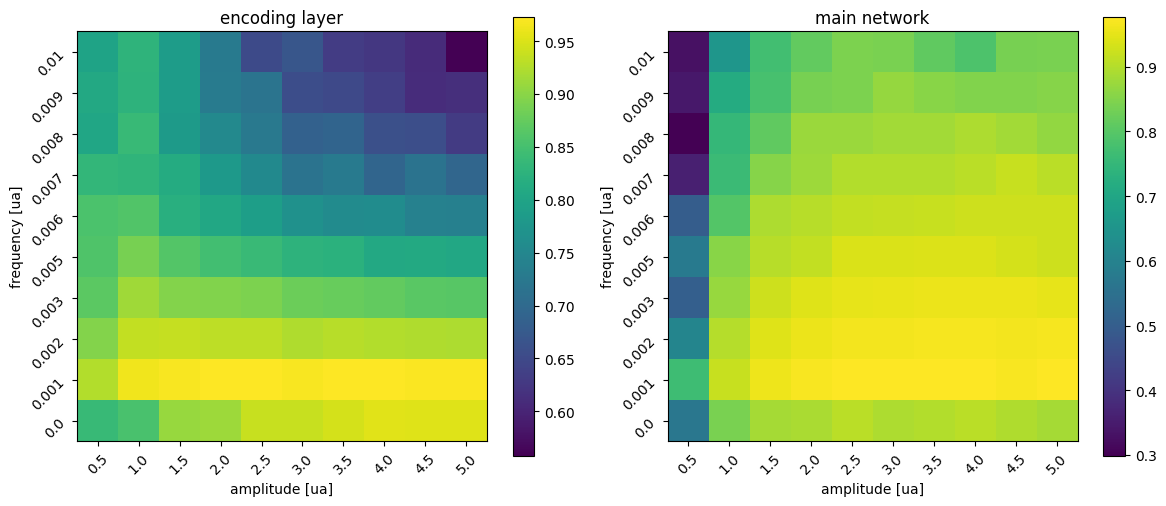

In [173]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12,5)
)

ax[0].set_title("encoding layer")
im0 = ax[0].imshow(
    enc_stim_params_space[:,:],
    # vmin=0, vmax=1,
    cmap="viridis",
    origin="lower"
)
ax[0].set_yticks(range(enc_stim_params_space.shape[0]), np.round(frequency_range, 3), rotation=45)
ax[0].set_xticks(range(enc_stim_params_space.shape[-1]), scale_range, rotation=45)
ax[0].set_ylabel("frequency [ua]")
ax[0].set_xlabel("amplitude [ua]")
fig.colorbar(im0, ax=ax[0])

ax[1].set_title("main network")
im1 = ax[1].imshow(
    main_stim_params_space,
    # vmin=0, vmax=1,
    cmap="viridis",
    origin="lower"
)
ax[1].set_yticks(range(main_stim_params_space.shape[0]), np.round(frequency_range, 3), rotation=45)
ax[1].set_xticks(range(main_stim_params_space.shape[-1]), scale_range, rotation=45)
ax[1].set_ylabel("frequency [ua]")
ax[1].set_xlabel("amplitude [ua]")
fig.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()

## Go to decod this

In [7]:
# for the decoding we have to move to the windows part